Two Sample Unpaired T-Test
===
Author: Christopher Lin <clin5@bidmc.harvard.edu>

**NOTE**: This notebook does not specify exchangability blocks, so the full cohort must be exchangeable

In [1]:
import pandas as pd
from nilearn import image, plotting
import numpy as np
import os
from nimlab.software import call_palm
from matplotlib import pyplot as plt
from glob import glob


%matplotlib inline

/usr/local/lib/python2.7/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/nilearn/__init__.py:73: DeprecationWarning: Python2 support is deprecated and will be removed in the next release. Consider switching to Python 3.6 or 3.7.
  _python_deprecation_warnings()


Set up file dataframe
===
The T-test is set up in accordance with the [FSL GLM recipe](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Two-Group_Difference_.28Two-Sample_Unpaired_T-Test.29). An alternate design for the design matrix would be to code group membership as a single dummy variable, and include a column of all 1s for an intercept term. 

In [2]:
# Point to your csv files
group1_filelist = glob('./data/sphere_conn/*')
group2_filelist = glob('./src_data/Prosopagnosia/subjects/*/Connectivity/*T.nii.gz')


# Select columns of csv to use and specify group membership
group1_df = pd.DataFrame()
group1_df['file'] = group1_filelist
group1_df['group1'] = 1
group1_df['group2'] = 0

group2_df = pd.DataFrame()
group2_df['file'] = group2_filelist
group2_df['group1'] = 0
group2_df['group2'] = 1

In [3]:

df = pd.DataFrame(columns=['group1', 'group2', 'file'])
df = df.append(group1_df, ignore_index=True, sort=False)
df = df.append(group2_df, ignore_index=True, sort=False)


Set up PALM config matrices
===
Two directories are created: `./palm_config` and `./palm_output`. 

`./palm_config` contains the csv versions of the design and contrast matrices, as well as the FSL formatted versions of them. This folder also contains the concatenated NIFTI image that PALM takes as input. 

`./palm_output` contains the output from PALM

In [4]:
if not os.path.exists('./palm_config'):
    os.makedirs('./palm_config')
    
if not os.path.exists('./palm_output'):
    os.makedirs('./palm_output')

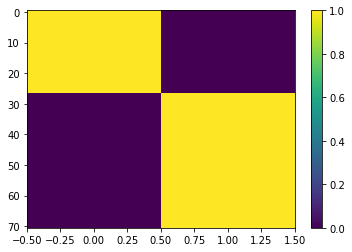

In [5]:
# Set up design matrix
design_matrix=pd.DataFrame({'group1':pd.to_numeric(df['group1']),
                            'group2':pd.to_numeric(df['group2'])})



plt.imshow(design_matrix, interpolation='nearest', aspect='auto')
plt.colorbar()
design_matrix.to_csv('./palm_config/design.csv', header=False, index=False,sep="\t")
!Text2Vest ./palm_config/design.csv ./palm_config/design.mat

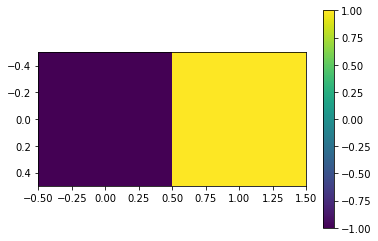

In [6]:
# Set up contrast matrix. The contrast only needs one row since we're using the twotailed flag later. 
contrast_matrix=pd.DataFrame(np.asarray([[-1,1]]))
plt.imshow(contrast_matrix)
plt.colorbar()
contrast_matrix.to_csv('./palm_config/contrast.csv', header=False, index=False,sep="\t")
!Text2Vest ./palm_config/contrast.csv ./palm_config/contrast.con

In [7]:
# Concatenate nifti files
concat = image.concat_imgs(df['file'])
concat.to_filename('palm_config/concat.nii')

Run PALM!
===
Options to note: 

`-n 2000` specifies that 2000 permutations should be run

`-twotail` calculates the contrast as two tailed tests. This makes it unncessary to have two contrasts. 

`-T` specifies that TFCE should be enabled. Voxelwise outputs are still generated when this option is enabled, so it's advisable to leave it on. 

`-fdr` computes the FDR p values as well

`-accel tail` specifies the [acceleration option](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM/FasterInference). Alex recommends using tail acceleration with 2000 permutations. 

`-save1-p` indicates that the p-value maps should be saved as 1-p. This makes the maps easier to visualize. 

In [8]:
!palm -o ./palm_output/ -i ./palm_config/concat.nii -d ./palm_config/design.mat -t ./palm_config/contrast.con -n 10 -twotail -T -fdr -accel tail -save1-p

             ___         ___                         ___
            /  /\       /  /\                       /__/\
           /  /::\     /  /::\                     |  |::\
          /  /:/\:\   /  /:/\:\    ___     ___     |  |:|:\
         /  /:/~/:/  /  /:/~/::\  /__/\   /  /\  __|__|:|\:\
        /__/:/ /:/  /__/:/ /:/\:\ \  \:\ /  /:/ /__/::::| \:\
        \  \:\/:/   \  \:\/:/__\/  \  \:\  /:/  \  \:\~~\__\/
         \  \::/     \  \::/        \  \:\/:/    \  \:\
          \  \:\      \  \:\         \  \::/      \  \:\
           \  \:\      \  \:\         \__\/        \  \:\
            \__\/       \__\/                       \__\/

                 Permutation Analysis of Linear Models
Running PALM alpha115 using MATLAB 9.3.0.713579 (R2017b) with the following options:
-o ./palm_output/
-i ./palm_config/concat.nii
-d ./palm_config/design.mat
-t ./palm_config/contrast.con
-n 10
-twotail
-T
-fdr
-accel tail
-save1-p
Found FSL in /usr/share/fsl/5.0
Found FreeSurfer in /data1/apps